In [ ]:
import pandas as pd

# import techminer.jupyter as jpl
from techminer.analytics import load_scopus

filepath = "../data/papers/urban-agriculture.csv"
df = pd.read_csv(filepath)
df = load_scopus(df)


In [ ]:
import ipywidgets as widgets
from ipywidgets import Layout

import techminer.analytics as tc
import techminer.plots as plt

# import matplotlib.pyplot as plt

In [ ]:
COLORMAPS = [
    "Greys",
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
    "Pastel1",
    "Pastel2",
    "Paired",
    "Accent",
    "Dark2",
    "Set1",
    "Set2",
    "Set3",
    "tab10",
    "tab20",
    "tab20b",
    "tab20c",
]

In [ ]:
COLUMNS = [
    "Author Keywords",
    "Authors",
    "Countries",
    "Country 1st",
    "Document type",
    "Index Keywords",
    "Institution 1st"
    "Institutions",
    "Keywords",
    "Source title",
]

In [ ]:
def menu_descriptive_stats(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_analysis_by_term_per_term_per_year(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_occurrence(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_co_occurrence(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_autocorrelation(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_correlation(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_factor_analysis(x):
    return widgets.Text("TO-DO")

In [ ]:
def menu_analysis_by_year(x):
    def compute(selected, plot_type, cmap):
        df = tc.summary_by_year(x)
        df = df[data[selected]]
        plot = plots[plot_type]
        output.clear_output()
        with output:
            display(plot(df, cmap=cmap))

    #
    # Options
    #
    data = {
        "Documents by Year": ["Year", "Num Documents"],
        "Cum. Documents by Year": ["Year", "Num Documents (Cum)"],
        "Times Cited by Year": ["Year", "Times Cited"],
        "Cum. Times Cited by Year": ["Year", "Times Cited (Cum)"],
        "Avg. Times Cited by Year": ["Year", "Avg. Times Cited"],
    }
    plots = {"bar": plt.bar, "barh": plt.bar}
    #
    selected = widgets.Dropdown(
        options=list(data.keys()),
        value=list(data.keys())[0],
        disable=False,
    )
    plot_type = widgets.Dropdown(
        options=["bar", "barh"], disable=False,
    )
    cmap = widgets.Dropdown(options=COLORMAPS, disable=False,)
    #
    output = widgets.Output()
    with output:
        display(
            widgets.interactive_output(
                compute, {"selected": selected, "plot_type": plot_type, "cmap": cmap}
            )
        )
    #
    left_box = widgets.VBox(
        [
            widgets.VBox([widgets.Label(value="Plot:"), selected]),
            widgets.VBox([widgets.Label(value="Plot type:"), plot_type]),
            widgets.VBox([widgets.Label(value="Colormap:"), cmap]),
        ],
        layout=Layout(height="350px", border="1px solid gray"),
    )
    right_box = widgets.VBox([output])
    return widgets.HBox([left_box, right_box])

In [ ]:
def menu_analysis_by_term(x):
    def tab_term_plots():
        def compute_by_term(term, top_n, analysis_type, plot_type, cmap):
            df = tc.summary_by_term(x, term)
            if analysis_type == "Frequency":
                df = df.sort_values(
                    ["Num Documents", "Cited by", term], ascending=False
                )
                df = df[[term, "Num Documents"]].head(top_n)
            else:
                df = df.sort_values(
                    ["Cited by", "Num Documents", term], ascending=False
                )
                df = df[[term, "Cited by"]].head(top_n)
            df = df.reset_index(drop=True)
            plot = plots[plot_type]
            output.clear_output()
            with output:
                display(plot(df, cmap=cmap))

        columns = [z for z in COLUMNS if z in x.columns]
        term = widgets.Select(options=columns, ensure_option=True, disabled=False,)

        analysis_type = widgets.Dropdown(
            options=["Frequency", "Citation"], value="Frequency", disable=False,
        )
        #
        plots = {"bar": plt.bar, "barh": plt.bar}
        plot_type = widgets.Dropdown(options=list(plots.keys()), disable=False,)
        cmap = widgets.Dropdown(options=COLORMAPS, disable=False,)
        #
        top_n = widgets.IntSlider(
            value=10,
            min=10,
            max=50,
            step=1,
            disabled=False,
            continuous_update=False,
            orientation="horizontal",
            readout=True,
            readout_format="d",
        )
        #
        output = widgets.Output()
        with output:
            display(
                widgets.interactive_output(
                    compute_by_term,
                    {
                        "term": term,
                        "top_n": top_n,
                        "analysis_type": analysis_type,
                        "plot_type": plot_type,
                        "cmap": cmap,
                    },
                )
            )
        #
        left_box = widgets.VBox(
            [
                widgets.VBox([widgets.Label(value="Term to analyze:"), term]),
                widgets.VBox([widgets.Label(value="Analysis type:"), analysis_type]),
                widgets.VBox([widgets.Label(value="Top n terms:"), top_n]),
                widgets.VBox([widgets.Label(value="Plot type:"), plot_type]),
                widgets.VBox([widgets.Label(value="Colormap:"), cmap]),
            ],
            layout=Layout(height="400px", border="1px solid gray"),
        )
        right_box = widgets.VBox([output])
        return widgets.HBox([left_box, right_box])

    def tab_worldmap():
        def compute_worldmap(term, analysis_type, cmap):
            df = tc.summary_by_term(x, term)
            if analysis_type == "Frequency":
                df = df[[term, "Num Documents"]]
            else:
                df = df[[term, "Cited by"]]
            df = df.reset_index(drop=True)
            output.clear_output()
            with output:
                display(plt.worldmap(df, cmap=cmap))

        term = widgets.Select(
            options=["Countries", "Country 1st"], ensure_option=True, disabled=False,
        )
        analysis_type = widgets.Dropdown(
            options=["Frequency", "Citation"], value="Frequency", disable=False,
        )
        cmap = widgets.Dropdown(options=COLORMAPS, disable=False,)
        #
        output = widgets.Output()
        with output:
            display(
                widgets.interactive_output(
                    compute_worldmap,
                    {"term": term, "analysis_type": analysis_type, "cmap": cmap,},
                )
            )
        #
        left_box = widgets.VBox(
            [
                widgets.VBox([widgets.Label(value="Term to analyze:"), term]),
                widgets.VBox([widgets.Label(value="Analysis type:"), analysis_type]),
                widgets.VBox([widgets.Label(value="Colormap:"), cmap]),
            ],
            layout=Layout(height="400px", border="1px solid gray"),
        )
        right_box = widgets.VBox([output])
        return widgets.HBox([left_box, right_box])

    #

    tab_nest = widgets.Tab()
    tab_nest.children = [tab_term_plots(), tab_worldmap()]
    tab_nest.set_title(0, "Term analysis")
    tab_nest.set_title(1, "Worldmap")
    return tab_nest

In [ ]:
def dashboard(x):
    m = [
        (menu_descriptive_stats, "Descriptive statistics"),
        (menu_analysis_by_year, "Analysis by year"),
        (menu_analysis_by_term, "Analysis by term"),
        (menu_analysis_by_term_per_year, "Analysis by term per year"),
        (menu_occurrence, "Occurrence analysis"),
        (menu_co_occurrence, "Co-occurrence analysis"),
        (menu_autocorrelation, "Autocorrelation analysis"),
        (menu_correlation, "Correlation analysis"),
        (menu_factor_analysis, "Factor analysis"),
    ]
    accordion = widgets.Accordion()
    widget_list = []
    for f, _ in m:
        widget_list.append(f(x))
    accordion.children = widget_list
    for index, t in enumerate(m):
        accordion.set_title(index, t[1])
    return accordion

In [ ]:
def menu_analysis_by_term_per_year(x):
    def compute(selected, plot_type, cmap):
        df = tc.summary_by_term_per_year(x)
        df = df[data[selected]]
        plot = plots[plot_type]
        output.clear_output()
        with output:
            display(plot(df, cmap=cmap))

    #
    # Options
    #
    data = {
        "Documents by Year": ["Year", "Num Documents"],
        "Cum. Documents by Year": ["Year", "Num Documents (Cum)"],
        "Times Cited by Year": ["Year", "Times Cited"],
        "Cum. Times Cited by Year": ["Year", "Times Cited (Cum)"],
        "Avg. Times Cited by Year": ["Year", "Avg. Times Cited"],
    }
    plots = {"bar": plt.bar, "barh": plt.bar}
    #
    selected = widgets.Dropdown(
        options=list(data.keys()),
        value=list(data.keys())[0],
        disable=False,
    )
    plot_type = widgets.Dropdown(
        options=["bar", "barh"], disable=False,
    )
    cmap = widgets.Dropdown(options=COLORMAPS, disable=False,)
    #
    output = widgets.Output()
    with output:
        display(
            widgets.interactive_output(
                compute, {"selected": selected, "plot_type": plot_type, "cmap": cmap}
            )
        )
    #
    left_box = widgets.VBox(
        [
            widgets.VBox([widgets.Label(value="Plot:"), selected]),
            widgets.VBox([widgets.Label(value="Plot type:"), plot_type]),
            widgets.VBox([widgets.Label(value="Colormap:"), cmap]),
        ],
        layout=Layout(height="350px", border="1px solid gray"),
    )
    right_box = widgets.VBox([output])
    return widgets.HBox([left_box, right_box])

In [ ]:
dashboard(df)

In [ ]:
df.columns

In [ ]:
def f(m, n, o):
    print('{}*{}*{}={}'.format(m, n, o, m*n*o))



a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')

out = widgets.interactive_output(f, {'m': a, 'n': b, 'o': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

In [ ]:
widgets.Select(
    # value='John',
    placeholder='Choose Someone',
    options=['Paul', 'John', 'George', 'Ringo'],
    description='Combobox:',
    ensure_option=True,
    disabled=False
)

In [ ]:
print(widgets.Dropdown.on_click.__doc__)

In [ ]:
jpl.summary_by_term(df, cmap="Blues")

In [ ]:
button = widgets.Button(description='Click here')
slider = widgets.IntSlider()
stacked = widgets.Stacked([button, slider])
stacked

In [ ]:
widgets.VBox([widgets.Label(value="The $m$ in $E=mc^2$:"), widgets.FloatSlider()])

In [ ]:
import ipywidgets as widgets

button = widgets.Button(description="Click here")
slider = widgets.IntSlider()
stacked = widgets.Stacked([button, slider])
stacked  # will show only the button

In [ ]:
tab_nest = widgets.Tab()
tab_nest.children = [accordion, accordion]
tab_nest.titles = ("An accordion", "Copy of the accordion")
tab_nest

In [ ]:
tab_contents = ["P0", "P1", "P2", "P3", "P4"]
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = [str(i) for i in range(len(children))]
tab

In [ ]:
accordion = widgets.Accordion(
    children=[widgets.IntSlider(), widgets.Text()], titles=("Slider", "Text")
)
accordion

In [ ]:
# jpl.summary_by_year(df, cmap='Blues')

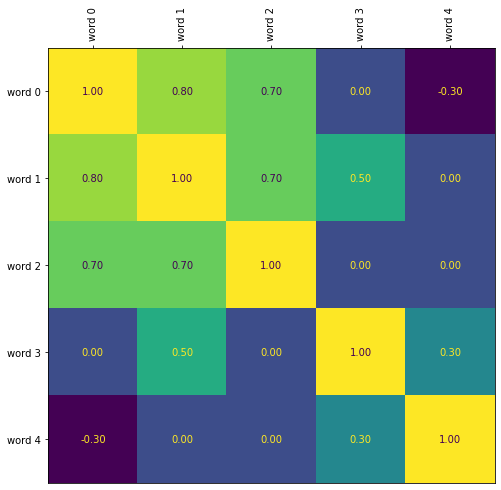

In [3]:
import textwrap
import matplotlib.pyplot as plt

TEXTLEN = 30

def heatmap(x, figsize=(8,8), **kwargs):
    
    fig = plt.Figure(figsize=figsize)
    ax = fig.subplots()
    x = x.copy()
    result = ax.pcolor(np.transpose(x.values), **kwargs,)
    x.columns = [textwrap.shorten(text=w, width=TEXTLEN) for w in x.columns]
    x.index = [textwrap.shorten(text=w, width=TEXTLEN) for w in x.index]
    ax.set_xticks(np.arange(len(x.index))+ 0.5)
    ax.set_xticklabels(x.index)
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_yticks(np.arange(len(x.columns))+ 0.5)
    ax.set_yticklabels(x.columns)
    ax.invert_yaxis()

    if "cmap" in kwargs:
        cmap = plt.cm.get_cmap(kwargs["cmap"])
    else:
        cmap = plt.cm.get_cmap()

    if all(x.dtypes == "int64"):
        fmt = "{:3.0f}"
    else:
        fmt = "{:3.2f}"

    for idx_row, row in enumerate(x.index):
        for idx_col, col in enumerate(x.columns):
            if abs(x.at[row, col]) > x.values.max().max() / 2.0:
                color = cmap(0.0)
            else:
                color = cmap(1.0)
            ax.text(
                idx_row + 0.5,
                idx_col + 0.5,
                fmt.format(x.at[row, col]),
                ha="center",
                va="center",
                color=color,
            )
    ax.xaxis.tick_top()

    return fig


df = pd.DataFrame(
    {
       'word 0': [1.00, 0.80, 0.70, 0.00,-0.30],
        'word 1': [0.80, 1.00, 0.70, 0.50, 0.00],
        'word 2': [0.70, 0.70, 1.00, 0.00, 0.00],
        'word 3': [0.00, 0.50, 0.00, 1.00, 0.30],
        'word 4': [-0.30, 0.00, 0.00, 0.30, 1.00],
    },
    index=['word {:d}'.format(i) for i in range(5)]
)
heatmap(df)